# Workflow for Training New St. Vrain Natural Flow Prediction Models for Hydrology outside the normal Historical Record

The cell below loads in all the required Python libraries for training new versions of the St Vrain Prediction Model.

In [1]:
# standard libraries
import os
import pickle
# data read-in / manipulation libraries
import pandas as pd
import numpy as np
# model building libraries
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# graphing libraries
import plotly.graph_objects as go

The cell below reads in the raw Natural Flow Data that the St. Vrain Prediction Models is built from.  
Future users may need to adjust the stvrain_path variable and the sheetname keyword argument.

In [2]:
# Excel file path - user input
stvrain_path = r"./NatFlowData_CRSS_StVrain.xlsx" # hard-coded, potentially change for other users
# read-in 29 point natural flow data from Excel/csv
nf_hist_df = pd.read_excel(stvrain_path, sheet_name="ZackNF", index_col=0, header=[0,1]) # change sheet_name if needed
# display is a replacement for print() in jupyter notebooks
display(nf_hist_df)

Date,UpperColoradoReach.Inflow,ColoRAbv09095500:GainsAbvCameo.Local Inflow,TaylorRiver.Inflow,TaylorAboveBlueMesa:GainsAboveBlueMesa.Local Inflow,GunnisonRiverAboveCrystal:GainsAboveCrystal.Local Inflow,GunnisonRiverAboveGrandJunction:GainsGunnisonRiverAbvGrandJunction.Local Inflow,DoloresRiver.Inflow,GrandValleyReach:GainsAboveCisco.Local Inflow,GreenRAboveGage09211200.Inflow,Gage09211200ToGage09217000:GainsAbv09217000.Local Inflow,...,ColoradoRAbvPowell:GainsAboveLeesFerry.Local Inflow,CoRivPowellToVirgin:PariaGains.LocalInflow,CoRivPowellToVirgin:LittleCoR.LocalInflow,CoRivPowellToVirgin:GainsAboveGC.LocalInflow,VirginRiver.Inflow,CoRivVirginToMead:GainsAboveHoover.LocalInflow,CoRivMeadToMohave:GainsAboveDavis.LocalInflow,CoRivMohaveToHavasu:BillWilliamsRiver.LocalInflow,CoRivMohaveToHavasu:GainsAboveParker.LocalInflow,AboveImperialDamColoradoR:GainsOnColoRAboveImperialDam.LocalInflow
,(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),...,(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month)
1905-10-31,66982,45086,6375,21625,3900,42472,23495,-4175,28000,2010,...,-3916,4398,8058,1529,5279,28837,-11318,133,57535,-24994
1905-11-30,60131,42706,4097,20903,4200,30014,6836,15103,24000,1441,...,23450,2746,812,5831,6857,34679,6792,265,7122,-6261
1905-12-31,37105,29707,3981,23019,2200,10557,2001,4950,18000,1513,...,-8598,1445,23,4070,10396,2030,7730,528,6332,2436
1906-01-31,37525,31693,3770,22230,2600,5317,2929,1786,18000,2435,...,820,2717,72,3150,11961,34792,-41977,398,-12154,-59403
1906-02-28,38047,21806,3898,18102,3500,16175,4306,3506,17000,-1202,...,24584,2848,7259,1967,15361,69835,-43645,5304,14311,20591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,88912,51889,4037,35582,3471,79158,39360,-2518,74105,-10147,...,382,228,116,23259,5410,-5129,-17688,2213,-1183,-56757
2020-09-30,62284,34406,5529,22724,2662,48359,25065,-2003,45900,-6669,...,10366,351,0,23688,4584,320,-1271,1957,1068,-20619
2020-10-31,57953,32671,4250,16967,1839,28016,7831,1776,36244,-6085,...,-7300,461,0,24510,6281,-12198,-12168,1659,19223,-4828


The 29 point natural flow data is in monthly values we will need annual total sums for model prediction. <br>
The cell below groups the natural flow dataframe by the calendar year and then sums the values of the months to a single annual value. <br>
The first row of the resulting dataframe is dropped because 1905 does not contain all 12 months and would be invalid.

In [3]:
# annual summary dataframe for the 29 point natural flow data
# note that nf_hist_df is directly mutated here. (be careful)
nf_hist_df = nf_hist_df.groupby(nf_hist_df.index.year).sum()
# row 0 for 1905 is dropped via index loc (iloc) selection
nf_hist_df = nf_hist_df.iloc[1:]
display(nf_hist_df)

Date,UpperColoradoReach.Inflow,ColoRAbv09095500:GainsAbvCameo.Local Inflow,TaylorRiver.Inflow,TaylorAboveBlueMesa:GainsAboveBlueMesa.Local Inflow,GunnisonRiverAboveCrystal:GainsAboveCrystal.Local Inflow,GunnisonRiverAboveGrandJunction:GainsGunnisonRiverAbvGrandJunction.Local Inflow,DoloresRiver.Inflow,GrandValleyReach:GainsAboveCisco.Local Inflow,GreenRAboveGage09211200.Inflow,Gage09211200ToGage09217000:GainsAbv09217000.Local Inflow,...,ColoradoRAbvPowell:GainsAboveLeesFerry.Local Inflow,CoRivPowellToVirgin:PariaGains.LocalInflow,CoRivPowellToVirgin:LittleCoR.LocalInflow,CoRivPowellToVirgin:GainsAboveGC.LocalInflow,VirginRiver.Inflow,CoRivVirginToMead:GainsAboveHoover.LocalInflow,CoRivMeadToMohave:GainsAboveDavis.LocalInflow,CoRivMohaveToHavasu:BillWilliamsRiver.LocalInflow,CoRivMohaveToHavasu:GainsAboveParker.LocalInflow,AboveImperialDamColoradoR:GainsOnColoRAboveImperialDam.LocalInflow
,(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),...,(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month)
1906,2763072,1743827,196474,1271454,237400,1126729,645028,197486,1530600,143449,...,886435,22433,251227,68262,116584,119482,-46987,18933,52398,-300761
1907,3081437,1700573,223675,1486653,254700,901188,659614,136148,1993900,123284,...,818195,17427,432145,253602,115329,217141,12319,84568,-29965,-108356
1908,1649464,1224669,154109,786219,146600,586817,438902,214486,1140300,101565,...,-258097,22536,135563,326248,126253,327918,137995,123017,-47087,-183789
1909,3215703,1958192,251808,1576720,276600,923322,975058,-23894,2067800,161231,...,-33810,19744,184638,253175,114546,329061,432618,111677,-128057,-179842
1910,1847184,1428398,149178,1065850,222800,916096,777540,137973,1267900,113201,...,339009,20034,141902,188064,134605,655399,277107,58494,-93519,-222470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,2106977,1243413,122128,796749,200108,1063634,773373,39587,1128697,53193,...,184844,17418,51513,330455,117854,153749,-260799,15053,225854,-226104
2017,2181450,1181741,183123,1118073,214091,1183310,879500,-184324,2599990,26734,...,241691,15744,112807,310507,157534,183222,-212374,25787,151602,-272665
2018,1474316,745990,81528,376184,97410,546353,275536,22451,1473163,113783,...,135025,16822,80285,295634,91523,59763,-166960,42244,85307,-299647


The St. Vrain Natural Flow and Gauge data is read from the same Excel Workbook, but a different sheet.

In [4]:
# st. vrain natural flow value is the sum for the year
nf_stvrain_df = pd.read_excel(stvrain_path, sheet_name="ZackStVrain", # change sheet_name if needed
                              index_col=0, header=[0,1]) 
display(nf_stvrain_df)

Year,Natural Flow (Cal Year),St. Vrain Gaged Streamflow (CY)
,acre-feet,acre-feet
1906,149314.2240,117360
1907,189603.2858,154462
1908,91389.0603,64017
1909,165939.3530,132670
1910,76251.6143,50077
...,...,...
2016,109972.0670,81130
2017,139323.9440,108160
2018,83574.9239,56821


Notice that both the nf_hist_df and nf_stvrain_df uses a MultiIndex header for the name and units associated with each column.

In [5]:
print("29 Point Historical Natural Flow Point Columns:\n")
print(nf_hist_df.columns[0:3]) # first five columns only
print("\n\nSt. Vrain Natural Flow and Gauge Columns:\n")
print(nf_stvrain_df.columns)

29 Point Historical Natural Flow Point Columns:

MultiIndex([(                  'UpperColoradoReach.Inflow', '(ac-ft/month)'),
            ('ColoRAbv09095500:GainsAbvCameo.Local Inflow', '(ac-ft/month)'),
            (                         'TaylorRiver.Inflow', '(ac-ft/month)')],
           names=['Date', None])


St. Vrain Natural Flow and Gauge Columns:

MultiIndex([(        'Natural Flow (Cal Year)', 'acre-feet'),
            ('St. Vrain Gaged Streamflow (CY)', 'acre-feet')],
           names=['Year', None])


Because each pandas dataframe column is a two part MultiIndex locator, a tuple will be needed to address each column.

**Based on previous analysis using:  
1.) Dynamic Time Warping Distance Metric  
2.) Wasserstein Distance Metric  
3.) Correlation Analysis  
in the Exploration Notebook it is determined that the "UpperColoradoReach.Inflow" node is likely the best predictor for St.Vrain.**

However, due to the magnitude differences in flow values from the UpperColoradoReach.Inflow and St. Vrain it is required to scale the data using a StandardScaler() or MinMaxScaler() object from the scikit-learn library.

In [6]:
# scaling UpperColoradoReach.Inflow data
# initial scaling objects for scaling data
hist_SS = StandardScaler()
vrain_SS = StandardScaler()

# scaling historial data
nf_hist_df_SS = pd.DataFrame(hist_SS.fit_transform(nf_hist_df),
                             columns=nf_hist_df.columns, index=nf_hist_df.index)

nf_stvrain_df_SS = pd.DataFrame(vrain_SS.fit_transform(nf_stvrain_df),
                                columns=nf_stvrain_df.columns, index=nf_stvrain_df.index)

# display scaled dataframe
display(nf_hist_df_SS)
print("\n\n")
display(nf_stvrain_df_SS)


Date,UpperColoradoReach.Inflow,ColoRAbv09095500:GainsAbvCameo.Local Inflow,TaylorRiver.Inflow,TaylorAboveBlueMesa:GainsAboveBlueMesa.Local Inflow,GunnisonRiverAboveCrystal:GainsAboveCrystal.Local Inflow,GunnisonRiverAboveGrandJunction:GainsGunnisonRiverAbvGrandJunction.Local Inflow,DoloresRiver.Inflow,GrandValleyReach:GainsAboveCisco.Local Inflow,GreenRAboveGage09211200.Inflow,Gage09211200ToGage09217000:GainsAbv09217000.Local Inflow,...,ColoradoRAbvPowell:GainsAboveLeesFerry.Local Inflow,CoRivPowellToVirgin:PariaGains.LocalInflow,CoRivPowellToVirgin:LittleCoR.LocalInflow,CoRivPowellToVirgin:GainsAboveGC.LocalInflow,VirginRiver.Inflow,CoRivVirginToMead:GainsAboveHoover.LocalInflow,CoRivMeadToMohave:GainsAboveDavis.LocalInflow,CoRivMohaveToHavasu:BillWilliamsRiver.LocalInflow,CoRivMohaveToHavasu:GainsAboveParker.LocalInflow,AboveImperialDamColoradoR:GainsOnColoRAboveImperialDam.LocalInflow
,(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),...,(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month),(ac-ft/month)
1906,1.143895,0.729398,1.029941,1.113337,0.328136,0.289179,-0.447298,0.857260,0.495090,1.104956,...,1.597757,0.213712,0.664358,-0.791764,-0.568195,-0.659345,-0.478929,-0.616673,0.506166,-0.081758
1907,1.708980,0.625657,1.653706,1.817496,0.518957,-0.364122,-0.405524,0.487689,1.589285,0.713040,...,1.377198,-0.410016,2.135518,0.530074,-0.581593,-0.273990,-0.204645,-0.070595,0.121404,0.926754
1908,-0.832714,-0.515757,0.058439,-0.474414,-0.673399,-1.274728,-1.037639,0.959688,-0.426699,0.290921,...,-2.101491,0.226545,-0.276180,1.048182,-0.464969,0.163127,0.376592,0.249298,0.041418,0.531363
1909,1.947297,1.243534,2.298844,2.112207,0.760517,-0.300009,0.497902,-0.476589,1.763818,1.450557,...,-1.376572,-0.121327,0.122880,0.527028,-0.589953,0.167638,1.739190,0.154950,-0.336837,0.552052
1910,-0.481769,-0.027131,-0.054637,0.440574,0.167096,-0.320940,-0.067786,0.498685,-0.125340,0.517072,...,-0.171582,-0.085194,-0.224634,0.062659,-0.375804,1.455342,1.019969,-0.287529,-0.175491,0.328613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,-0.020647,-0.470801,-0.674940,-0.439959,-0.083199,0.106418,-0.079720,-0.094106,-0.454102,-0.649211,...,-0.669859,-0.411138,-0.959644,1.078186,-0.554636,-0.524130,-1.467785,-0.648955,1.316472,0.309565
2017,0.111540,-0.618716,0.723780,0.611455,0.071035,0.453071,0.224225,-1.443206,3.020714,-1.163453,...,-0.486124,-0.619712,-0.461224,0.935918,-0.131015,-0.407832,-1.243825,-0.559649,0.969601,0.065510
2018,-1.143594,-1.663827,-1.605967,-1.816102,-1.215971,-1.391936,-1.505516,-0.197353,0.359438,0.528384,...,-0.830879,-0.485397,-0.725681,0.829844,-0.835745,-0.894991,-1.033790,-0.422728,0.659901,-0.075919


Year,Natural Flow (Cal Year),St. Vrain Gaged Streamflow (CY)
,acre-feet,acre-feet
1906,0.873931,0.880308
1907,2.054987,2.069505
1908,-0.824119,-0.829448
1909,1.361289,1.371025
1910,-1.267867,-1.276254
...,...,...
2016,-0.279367,-0.280940
2017,0.581070,0.585428
2018,-1.053187,-1.060095


In [7]:
# select only the UpperColoradoReach.Inflow data as the X predictor
X_uc = nf_hist_df_SS.loc[:,('UpperColoradoReach.Inflow', '(ac-ft/month)')].values
print("X numpy array current shape: {}".format(X_uc.shape))
print("Scikit-learn models require a 2-dimensional shape (n_samples, n_features)")
# reshape X data into n_samples, n_features
X_uc = X_uc.reshape(-1, 1)
print("X array reshaped: {}".format(X_uc.shape))

# y is the time-series of St. Vrain Natural Flow data
y_uc = nf_stvrain_df_SS.iloc[:,0].values
# y reshaped like X
y_uc = y_uc.reshape(-1, 1)
print("y array reshaped: {}".format(y_uc.shape))

X numpy array current shape: (115,)
Scikit-learn models require a 2-dimensional shape (n_samples, n_features)
X array reshaped: (115, 1)
y array reshaped: (115, 1)


In [8]:
# split data for validation for training a K-NN model without overfitting the data
X_train_uc, X_test_uc, y_train_uc, y_test_uc = train_test_split(X_uc, y_uc, test_size=0.25, random_state=42, shuffle=False)

In [9]:
# KNeighbors regressor object
neigh_uc = KNeighborsRegressor(n_neighbors=12, weights="distance")
# fit/train model
neigh_uc.fit(X_train_uc, y_train_uc)

KNeighborsRegressor(n_neighbors=12, weights='distance')

In [10]:
# predict from X_test to get out of sample R^2 or validated R^2
neigh_y_test_pred_uc = neigh_uc.predict(X_test_uc)
# predict in sample from X_train
neigh_y_train_pred_uc = neigh_uc.predict(X_train_uc)

In [11]:
# calculate R^2 score
r2_test_uc = r2_score(y_test_uc, neigh_y_test_pred_uc)
r2_train_uc = r2_score(y_train_uc, neigh_y_train_pred_uc)
print("R^2 from test set: {}".format(round(r2_test_uc, 2)))
print("R^2 from train set: {}".format(round(r2_train_uc, 2)))
print("R^2 from train should be higher than R^2 from test")

R^2 from test set: 0.49
R^2 from train set: 1.0
R^2 from train should be higher than R^2 from test


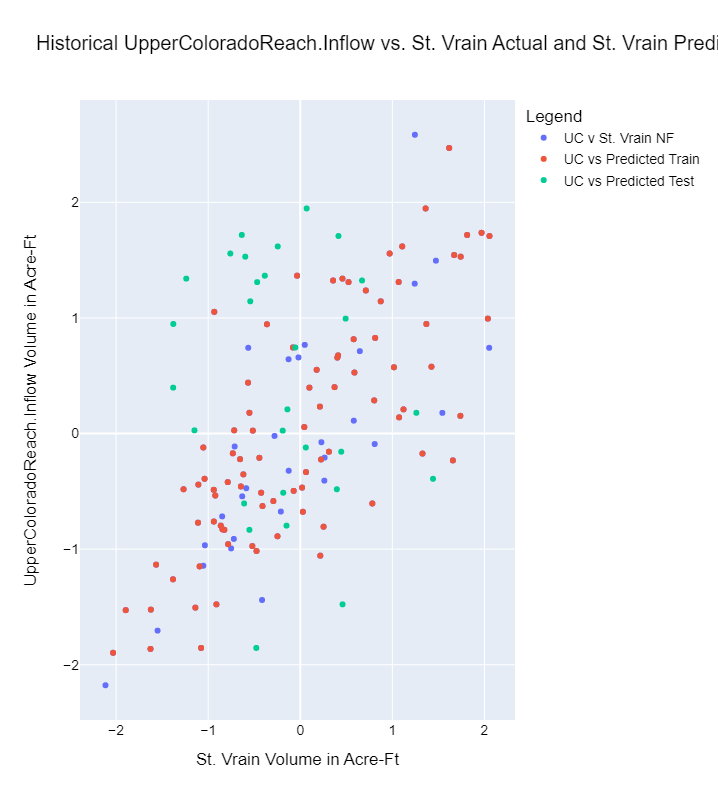

In [25]:
# graph
y_vals = nf_hist_df_SS.loc[:,('UpperColoradoReach.Inflow', '(ac-ft/month)')].values
fig = go.Figure()
fig.add_trace(go.Scatter(mode='markers', y=y_vals,
                         x=nf_stvrain_df_SS.iloc[:,0].values,
                         name="UC v St. Vrain NF"))
fig.add_trace(go.Scatter(mode='markers', y=y_vals,
                         x=neigh_y_train_pred_uc.flatten(),
                         name="UC vs Predicted Train"))
fig.add_trace(go.Scatter(mode='markers', y=y_vals,
                         x=neigh_y_test_pred_uc.flatten(),
                         name="UC vs Predicted Test"))

fig.update_layout(
        title="Historical UpperColoradoReach.Inflow vs. St. Vrain Actual and St. Vrain Predicted",
        yaxis_title="UpperColoradoReach.Inflow Volume in Acre-Ft",
        xaxis_title="St. Vrain Volume in Acre-Ft",
        legend_title="Legend",
        font=dict(
            family="Arial, monospace",
            size=14,
            color="Black"),
        autosize=False,
        width=800,
        height=800,
    )
fig.show()

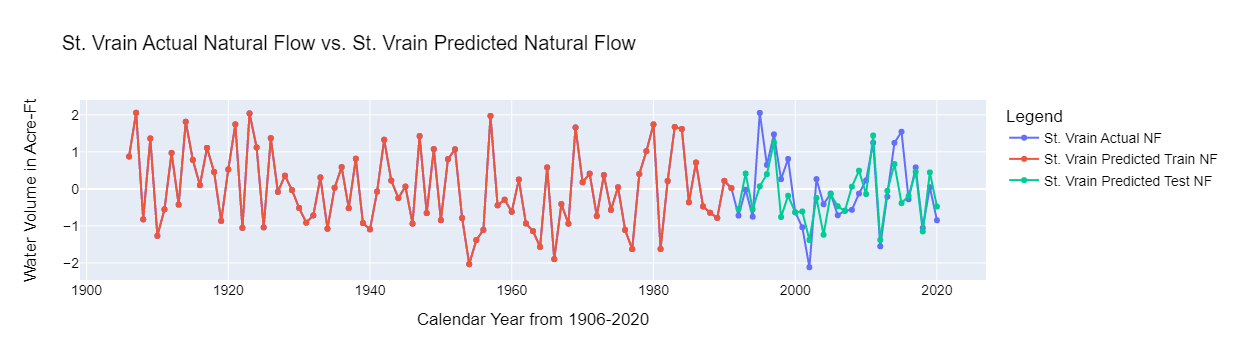

In [23]:
# graph
fig = go.Figure()
fig.add_trace(go.Scatter(mode='markers+lines', x=nf_stvrain_df.index.values,
                         y=y_uc.flatten(), name="St. Vrain Actual NF"))
fig.add_trace(go.Scatter(mode='markers+lines', x=nf_stvrain_df.index.values,
                         y=neigh_y_train_pred_uc.flatten(), name="St. Vrain Predicted Train NF"))
fig.add_trace(go.Scatter(mode='markers+lines', x=nf_stvrain_df.index.values[len(neigh_y_train_pred_uc.flatten()):],
                         y=neigh_y_test_pred_uc.flatten(), name="St. Vrain Predicted Test NF"))

fig.update_layout(
        title="St. Vrain Actual Natural Flow vs. St. Vrain Predicted Natural Flow",
        yaxis_title="Water Volume in Acre-Ft",
        xaxis_title="Calendar Year from 1906-2020",
        legend_title="Legend",
        font=dict(
            family="Arial, monospace",
            size=14,
            color="Black")
    )
fig.update_traces(mode="markers+lines", hovertemplate=None)
fig.update_layout(hovermode="x unified")
fig.show()

In [13]:
# CMIP5 scaled
# UpperColoradReach.Inflow maps to GlenwoodNF
# read-in 
df_g45_cmip5 = pd.read_csv("./cmip5/GlenwoodNF_csiro_mk3_RCP4.5.Inflow",
                        header=None, delimiter=r"\s+",
                        names=['Year', 'Month', 'Value'], engine="python")
df_g85_cmip5 = pd.read_csv("./cmip5/GlenwoodNF_csiro_mk3_RCP8.5.Inflow",
                        header=None, delimiter=r"\s+",
                        names=['Year', 'Month', 'Value'], engine="python")
# sum to annual values
df_g45_cmip5 = df_g45_cmip5.groupby(['Year']).sum()["Value"]
df_g85_cmip5 = df_g85_cmip5.groupby(['Year']).sum()["Value"]

# St. Vrain CMIP5 data
# read-in
df_stvrain_cmip5 = pd.read_csv("./cmip5/streamflow_cmip5_ncar_month_STVLC_af.csv", header=0)

# select RCP4.5/8.5 from St. Vrain data and summarize to annual values
df_v45_cmip5 = df_stvrain_cmip5.groupby(["Year"]).sum()["csiro-mk3-6-0_rcp45_r1i1p1"]
df_v85_cmip5 = df_stvrain_cmip5.groupby(["Year"]).sum()["csiro-mk3-6-0_rcp85_r1i1p1"]

# scaler objects
g45_SS = StandardScaler()
g85_SS = StandardScaler()
v45_SS = StandardScaler()
v85_SS = StandardScaler()

# apply scaler objects and create new scaled dataframes
df_g45_SS = pd.DataFrame(g45_SS.fit_transform(df_g45_cmip5.values.reshape(-1,1)),
                             columns=['Values'], index=df_g45_cmip5.index)
df_g85_SS = pd.DataFrame(g85_SS.fit_transform(df_g85_cmip5.values.reshape(-1,1)),
                              columns=['Values'], index=df_g85_cmip5.index)
df_v45_SS = pd.DataFrame(v45_SS.fit_transform(df_v45_cmip5.values.reshape(-1,1)),
                                columns=['Values'], index=df_v45_cmip5.index)
df_v85_SS = pd.DataFrame(v85_SS.fit_transform(df_v85_cmip5.values.reshape(-1,1)),
                                 columns=['Values'], index=df_v85_cmip5.index)

display(df_g45_SS)
display(df_g85_SS)
display(df_v45_SS)
display(df_v85_SS)

,Values
Year,
1950,0.321503
1951,-0.537511
1952,1.405533
1953,-0.770418
1954,-0.009765
...,...
2095,0.848480
2096,0.293631
2097,-0.462874


,Values
Year,
1950,0.547497
1951,-0.507327
1952,1.544783
1953,-0.473632
1954,0.213450
...,...
2095,-0.038825
2096,-0.981147
2097,-0.027292


,Values
Year,
1950,1.101612
1951,-0.140838
1952,1.849451
1953,-0.381993
1954,0.653200
...,...
2095,0.199615
2096,0.056236
2097,-0.798349


,Values
Year,
1950,1.003261
1951,-0.059281
1952,1.795409
1953,-0.324712
1954,0.636011
...,...
2095,-0.954092
2096,-1.013970
2097,-0.695472


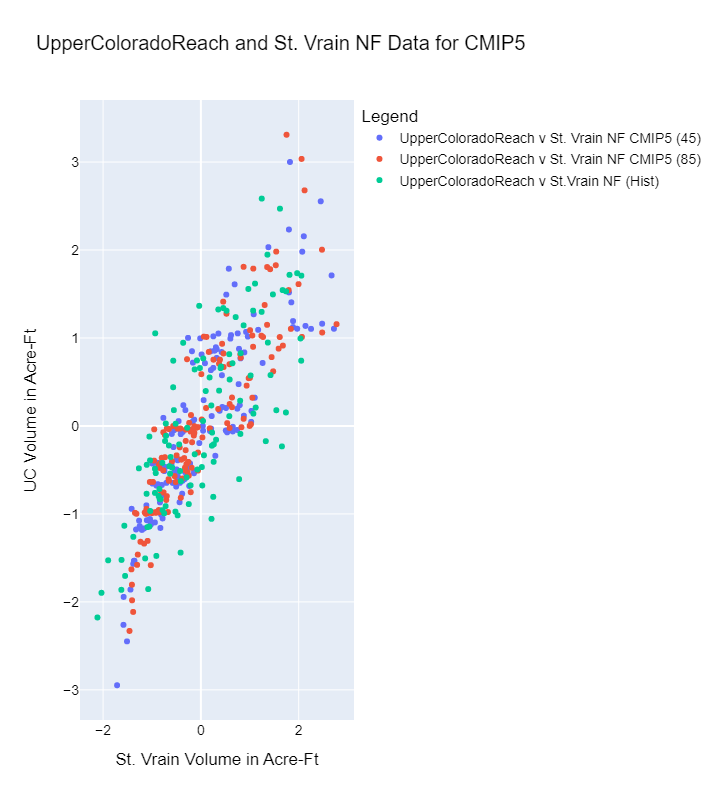

In [26]:
# CMIP5 graph
fig = go.Figure()
fig.add_trace(go.Scatter(mode='markers', y=df_g45_SS["Values"].values,
                         x=df_v45_SS["Values"].values, name="UpperColoradoReach v St. Vrain NF CMIP5 (45)"))
fig.add_trace(go.Scatter(mode='markers', y=df_g85_SS["Values"].values,
                         x=df_v85_SS["Values"].values, name="UpperColoradoReach v St. Vrain NF CMIP5 (85)"))
fig.add_trace(go.Scatter(mode='markers', y=nf_hist_df_SS.loc[:,('UpperColoradoReach.Inflow', '(ac-ft/month)')].values,
                             x=nf_stvrain_df_SS.iloc[:,0].values, name="UpperColoradoReach v St.Vrain NF (Hist)"))

fig.update_layout(
        title="UpperColoradoReach and St. Vrain NF Data for CMIP5",
        yaxis_title="UC Volume in Acre-Ft",
        xaxis_title="St. Vrain Volume in Acre-Ft",
        legend_title="Legend",
        font=dict(
            family="Arial, monospace",
            size=14,
            color="Black"),
        autosize=False,
        width=800,
        height=800,
    )
fig.show()

## Perform a comparison to CMIP5 Data

In [15]:
# Apply historically trained K-NN model to CMIP5 data
cmip5_dict_uc = {}
for n, v in zip(["45", "85"],[df_g45_SS["Values"].values, df_g85_SS["Values"].values]):
    cmip5_X = v.reshape(-1, 1)
    neigh_cmip5_pred = neigh_uc.predict(cmip5_X)
    cmip5_dict_uc[n] = {}
    cmip5_dict_uc[n]["values"] = v
    cmip5_dict_uc[n]["k_pred"] = neigh_cmip5_pred

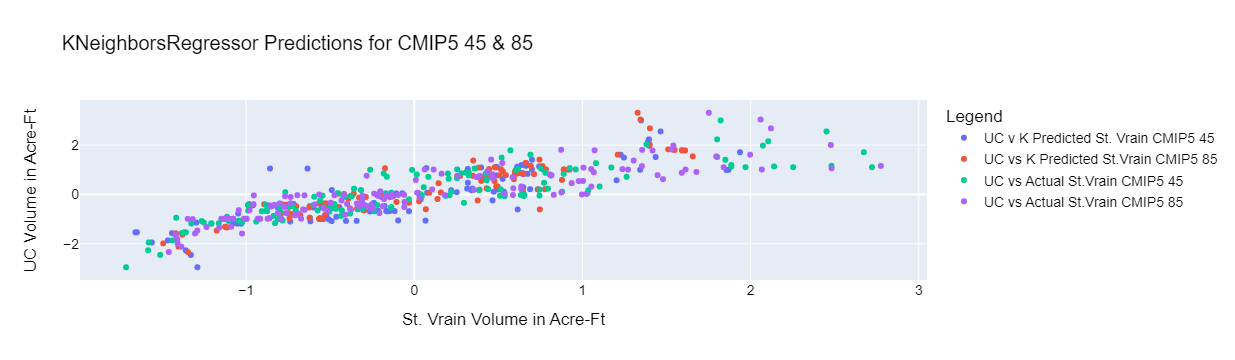

In [16]:
# graph predicted CMIP5 St. Vrain data
fig = go.Figure()
fig.add_trace(go.Scatter(mode='markers', y=df_g45_SS["Values"].values,
                         x=cmip5_dict_uc.get("45").get("k_pred").flatten(),
                         name="UC v K Predicted St. Vrain CMIP5 45"))
fig.add_trace(go.Scatter(mode='markers', y=df_g85_SS["Values"].values,
                         x=cmip5_dict_uc.get("85").get("k_pred").flatten(),
                         name="UC vs K Predicted St.Vrain CMIP5 85"))
fig.add_trace(go.Scatter(mode='markers', y=df_g45_SS["Values"].values,
                         x=df_v45_SS["Values"].values, name="UC vs Actual St.Vrain CMIP5 45"))
fig.add_trace(go.Scatter(mode='markers', y=df_g85_SS["Values"].values,
                         x=df_v85_SS["Values"].values, name="UC vs Actual St.Vrain CMIP5 85"))

fig.update_layout(
        title="KNeighborsRegressor Predictions for CMIP5 45 & 85",
        yaxis_title="UC Volume in Acre-Ft",
        xaxis_title="St. Vrain Volume in Acre-Ft",
        legend_title="Legend",
        font=dict(
            family="Arial, monospace",
            size=14,
            color="Black")
    )
fig.show()

In [17]:
r2_k45_uc = r2_score(df_v45_SS["Values"].values.reshape(-1, 1), cmip5_dict_uc.get("45").get("k_pred"))
r2_k85_uc = r2_score(df_v85_SS["Values"].values.reshape(-1, 1), cmip5_dict_uc.get("85").get("k_pred"))
print("R^2 score of the KNN regression from UC RCP4.5 data: {}".format(round(r2_k45_uc,3)))
print("R^2 score of the KNN regression from UC RCP8.5 data: {}".format(round(r2_k85_uc,3)))

R^2 score of the KNN regression from UC RCP4.5 data: 0.561
R^2 score of the KNN regression from UC RCP8.5 data: 0.654


## Save Trained Model to Pickle File for Future Use (CRITICAL)

In [18]:
# save KNN model to file
with open('./KNNmodel_v1.pkl','wb') as f:
    pickle.dump(neigh_uc, f)